# Predicting Sale Price of Homes in Ames Iowa

In [47]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

#display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
#importing data from SQL
#https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'
                       .format(postgres_user, postgres_pw, postgres_host,
                              postgres_port, postgres_db))

df = pd.read_sql_query('SELECT * FROM houseprices', con=engine)

engine.dispose()

In [3]:
#creating a copy of the original dataframe incase we need the unaltered data later
df_cpy = df

We start by examining the columns that are available and looking through the data for missing and problematic values to ensure the data we work with is trustworthy and to get a feel for which features we can leverage for prediction. 

In [4]:
#display original 81 columns
df.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

In [42]:
#examining timeline of data we have
df['yrsold'].unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [6]:
#df.info()

We have a number of categorical features that may be useful in our prediction. We will use one-hot encoding to transform these categorical strings into binary features.

In [7]:
#one-hot encoding categorical variables and creating correlation matrix
one_hot = pd.get_dummies(df, drop_first=True)
corr_df = one_hot.corr()

df = one_hot

We will need to do some minor data cleaning in order to fill missing values in our data. We will use the mean values to fill in missing values in the 'lotfrontage' and 'masvnrarea' features. This will help to ensure that the changes we make have minimal impact on prediction as they are being filled with a central value (mean). This will allow us to keep these rows and leverage information from other features in those rows rather than having to discard them. We see that there is also missing data for the 'garageyrblt' variable. It does not make sense to use the mean here as we might create cases where (on paper) our garage was built before the home. We will assume that if the value is missing then the garage was built at the same time as the home. 

In [8]:
#filling missing values
df['lotfrontage'].fillna(df['lotfrontage'].mean(), inplace=True)
df['garageyrblt'].fillna(df['yearbuilt'], inplace=True)
df['masvnrarea'].fillna(df['masvnrarea'].mean(), inplace=True)

#display number of null values
df.isnull().sum().sum()

0

We will perform principal component analysis to see how much of our data's variance can be explained through ten principal components. 

In [9]:
#Performing PCA 
scaled_df = StandardScaler().fit_transform(df)
sklearn_pca = PCA(n_components=10)
pca_arrays  = sklearn_pca.fit_transform(scaled_df)

#checking how much variance is explained using PCA
sklearn_pca.explained_variance_ratio_.sum()

0.22902863731340864

We see that with ten principle components we are only able to explain 22.9% of the variance. For this reason we will not be using PCA in our model. We will instead use the features that our present in our data, and make some new ones by combining similar or related metrics.  

In [10]:
#combining similar continuous features
df['garage'] = df['garagecars'] * df['garagearea'] * df['garageyrblt']
df['qual_liv_area'] = df['overallqual'] * df['grlivarea'] 
df['exter_kitchen_qual'] = df['exterqual_TA'] * df['kitchenqual_TA']

drop_list = ['garagecars', 'garagearea', 'garageyrblt', 'overallqual', 'grlivarea']
df = df.drop(drop_list, axis=1)

In [11]:
#finding 10 features that are most correlated with saleprice in either direction
top_10_abs = abs(df.corr()['saleprice']).sort_values(ascending=False)[1:11]
top_10_abs

qual_liv_area    0.832
garage           0.683
totalbsmtsf      0.614
firstflrsf       0.606
exterqual_TA     0.589
fullbath         0.561
totrmsabvgrd     0.534
yearbuilt        0.523
kitchenqual_TA   0.519
yearremodadd     0.507
Name: saleprice, dtype: float64

# Univariate analysis and Outlier detection

Now that we have some idea of which features are at least somewhat correlated with our target variable we will take a closer look at these features to detect and handle outliers to improve their predictive power. We will use the winsorization technique to 'cap' our data at reasonable quantiles. This will help to preserve our data and will reduce the impact that wild outliers may have on our predictions. We will use boxplots and histograms to examine each of the variables in our top-10 list above. We will then perform winsorization and rexamine the plots. Finally we will generate an updated list of correlations with the target variable (sale price) to see how our correlations have changed.

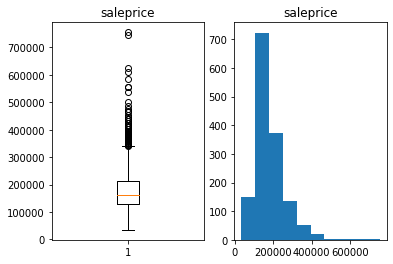

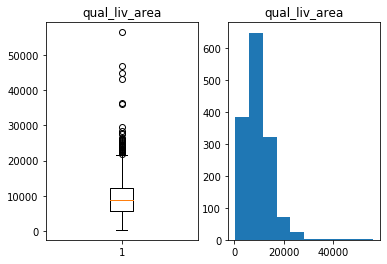

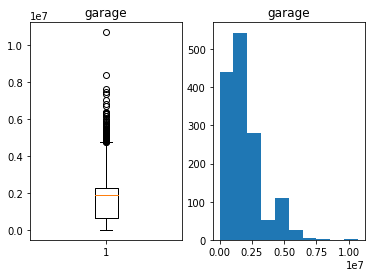

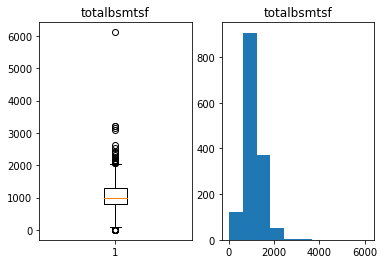

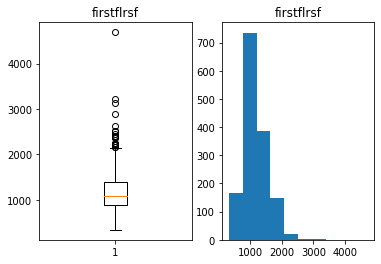

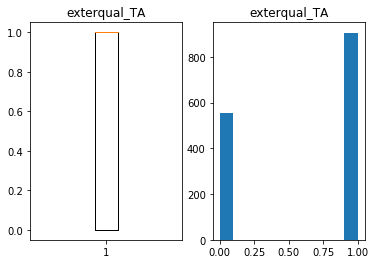

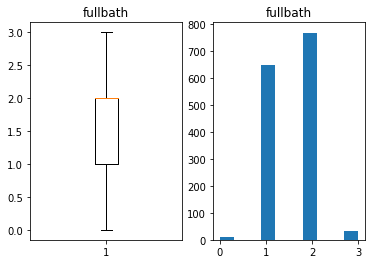

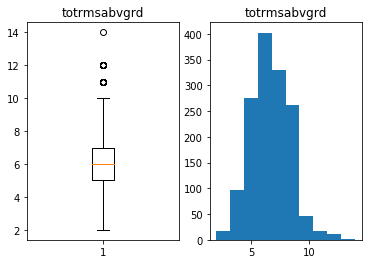

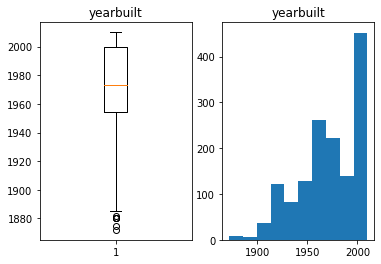

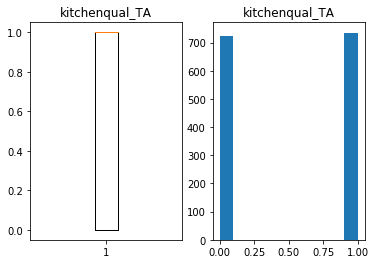

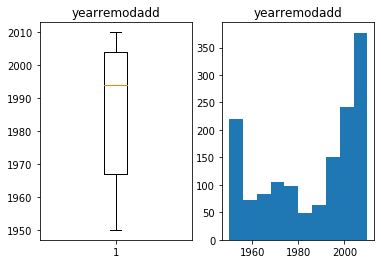

In [12]:
plt.subplot(1,2,1)
plt.boxplot(df['saleprice'])
plt.title('saleprice')

plt.subplot(1,2,2)
plt.hist(df['saleprice'])
plt.title('saleprice')
plt.show()

for i in top_10_abs.index:
    plt.subplot(1,2,1)
    plt.boxplot(df[i])
    plt.title(i)
    
    plt.subplot(1,2,2)
    plt.hist(df[i])
    plt.title(i)
    
    plt.show()

We can see that there are a few outliers in our data that might significantly skew out data. We will use winsorization to address the sale price, qual_liv_area, garage, totalbsmtsf and firstflrsf data as there are some significant outliers present. This can be seen by examining either of the plots above for the variable in question. 

In [13]:
winsorize(df['saleprice'], (0, .03), inplace=True)
winsorize(df['qual_liv_area'], (0, .05), inplace=True)
winsorize(df['garage'], (0, .05), inplace=True)
winsorize(df['totalbsmtsf'], (0, .02), inplace=True)
winsorize(df['firstflrsf'], (0, .01), inplace=True)



masked_array(data=[ 856, 1262,  920, ..., 1188, 1078, 1256],
             mask=False,
       fill_value=999999,
            dtype=int64)

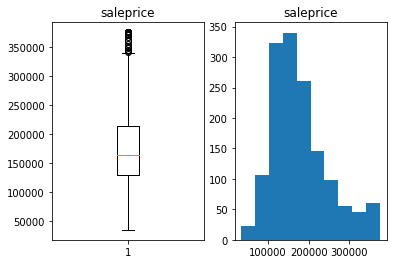

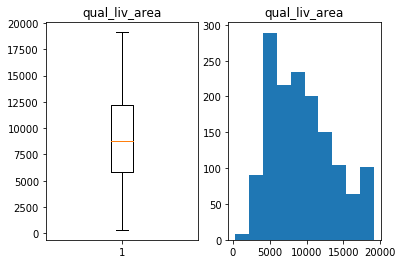

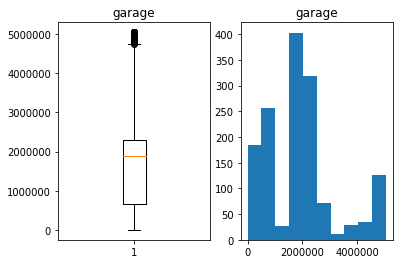

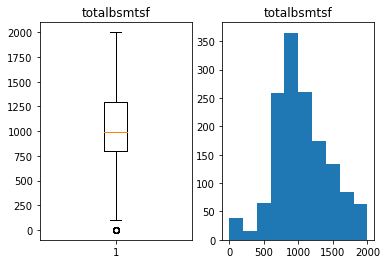

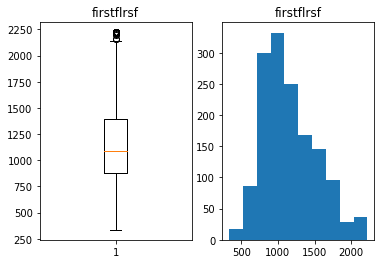

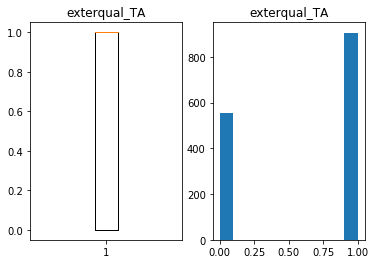

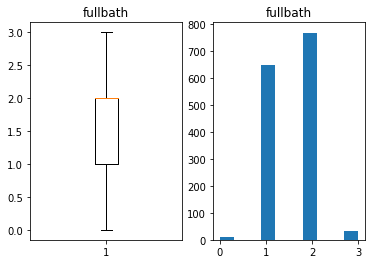

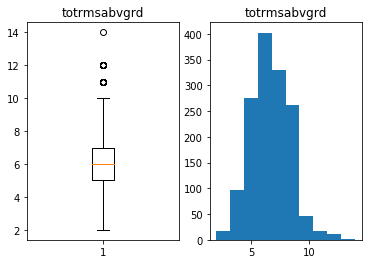

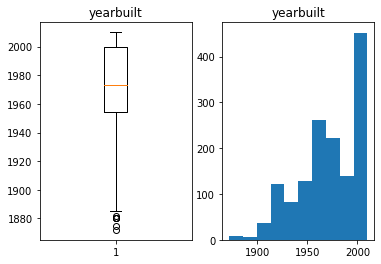

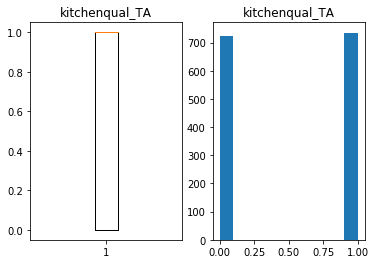

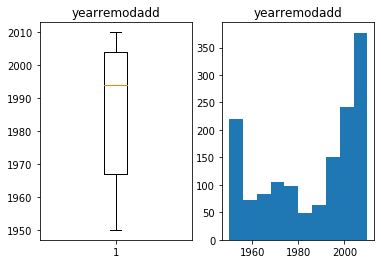

In [14]:
plt.subplot(1,2,1)
plt.boxplot(df['saleprice'])
plt.title('saleprice')

plt.subplot(1,2,2)
plt.hist(df['saleprice'])
plt.title('saleprice')
plt.show()

for i in top_10_abs.index:
    plt.subplot(1,2,1)
    plt.boxplot(df[i])
    plt.title(i)
    
    plt.subplot(1,2,2)
    plt.hist(df[i])
    plt.title(i)
    

    plt.show()

In [15]:
#examining how our winsorization has thus far influenced correlation with target variable
top_10_abs = abs(df.corr()['saleprice']).sort_values(ascending=False)[1:11]
top_10_abs

qual_liv_area        0.861
garage               0.720
totalbsmtsf          0.646
firstflrsf           0.627
exterqual_TA         0.622
fullbath             0.575
yearbuilt            0.559
kitchenqual_TA       0.552
yearremodadd         0.543
exter_kitchen_qual   0.540
Name: saleprice, dtype: float64

# Re-exmining correlations 

In [16]:
#saving names of features to list
pred_features = list(top_10_abs.index)

#Examining correlation between predictive features
top_10_abs_corr = df[top_10_abs.index].corr()
top_10_abs_corr

,qual_liv_area,garage,totalbsmtsf,firstflrsf,exterqual_TA,fullbath,yearbuilt,kitchenqual_TA,yearremodadd,exter_kitchen_qual
qual_liv_area,1.000,0.636,0.506,0.553,-0.577,0.658,0.410,-0.504,0.448,-0.495
garage,0.636,1.000,0.520,0.515,-0.512,0.468,0.515,-0.430,0.429,-0.416
totalbsmtsf,0.506,0.520,1.000,0.801,-0.402,0.329,0.409,-0.321,0.302,-0.310
firstflrsf,0.553,0.515,0.801,1.000,-0.315,0.384,0.287,-0.278,0.246,-0.264
exterqual_TA,-0.577,-0.512,-0.402,-0.315,1.000,-0.466,-0.589,0.672,-0.565,0.744
fullbath,0.658,0.468,0.329,0.384,-0.466,1.000,0.468,-0.419,0.439,-0.409
yearbuilt,0.410,0.515,0.409,0.287,-0.589,0.468,1.000,-0.460,0.593,-0.445
kitchenqual_TA,-0.504,-0.430,-0.321,-0.278,0.672,-0.419,-0.460,1.000,-0.577,0.945
yearremodadd,0.448,0.429,0.302,0.246,-0.565,0.439,0.593,-0.577,1.000,-0.570
exter_kitchen_qual,-0.495,-0.416,-0.310,-0.264,0.744,-0.409,-0.445,0.945,-0.570,1.000


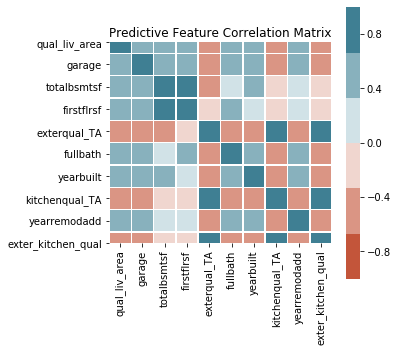

In [17]:
fig = plt.figure(figsize=(5,5))
ax = sns.heatmap(
    top_10_abs_corr, 
    cmap=sns.diverging_palette(20, 220), 
    square=True,
    vmin=-1,
    vmax=1,
    linewidths=.5).set_title('Predictive Feature Correlation Matrix')

Based on the above correlation matrix we can see that we encounter a situation where we have three sets of features that have high correlation with eachother. We see that qual_liv_area and totrmsabvgrd, firstflrsf and totalbsmtsf, and exterqual_TA and kitchenqual_TA are all highly correlated (>67%). After itterating through the feature engineering step it is clear that by combining these features results in worse correlation with the target variable in each case. For this reason the lower of each pair will be dropped. 

In [18]:
#dropping less correlated of each of the highly correlated feature pairs and displaying remainder
pred_features = [x for x in pred_features if x not in ('totrmsabvgrd','firstflrsf', 'kitchenqual_TA')]
pred_features

['qual_liv_area',
 'garage',
 'totalbsmtsf',
 'exterqual_TA',
 'fullbath',
 'yearbuilt',
 'yearremodadd',
 'exter_kitchen_qual']

In [19]:
#define target variable
Y = df['saleprice']

#define predictive variables
X = df[pred_features]

#splitting data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=5)

# OLS Model

In [20]:
#adding constant
X_train = sm.add_constant(X_train)

#fitting linear regression model to data
OLS_model_train = sm.OLS(y_train, X_train).fit()

#printing summary statistics
OLS_model_train.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     789.8
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:58:42   Log-Likelihood:                -13621.
No. Observations:                1168   AIC:                         2.726e+04
Df Residuals:                    1159   BIC:                         2.731e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.037e+06   1.11e+05     -9.370      0.000   -1.25e+06    -8.2e+05
qual_liv_area          9.7718      0.312     31.360      0.000       9.160      10.383
garage                 0.0083      0.001      9.372      0.000       0.007       0.010
totalbsmtsf           35.3745      2.575     13.736      0.000      30.322      40.427
exterqual_TA        -398.2904   2959.198     -0.135      0.893   -6204.276    5407.695
fullbath           -9116.3371   2058.301     -4.429      0.000   -1.32e+04   -5077.924
yearbuilt            260.4755     38.557      6.756      0.000     184.826     336.125
yearremodadd         289.9849     55.490      5.226      0.000     181.113     398.857
exter_kitchen_qual -7363.5289   2616.853     -2.814      0.005   -1.25e+04   -2229.230
==============================================================================
Omnibus:                      138.562   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1132.311
Skew:                          -0.187   Prob(JB):                    1.32e-246
Kurtosis:                       7.809   Cond. No.                     3.13e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.13e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
#adding constant
X_test = sm.add_constant(X_test)

#fitting linear regression model to data
OLS_model_test = sm.OLS(y_test, X_test).fit()

#printing summary statistics
OLS_model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     254.6
Date:                Tue, 08 Oct 2019   Prob (F-statistic):          1.74e-124
Time:                        10:58:42   Log-Likelihood:                -3351.6
No. Observations:                 292   AIC:                             6721.
Df Residuals:                     283   BIC:                             6754.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -9.964e+05    1.9e+05     -5.239      0.000   -1.37e+06   -6.22e+05
qual_liv_area          9.6861      0.582     16.638      0.000       8.540      10.832
garage                 0.0075      0.002      4.746      0.000       0.004       0.011
totalbsmtsf           33.3046      4.286      7.770      0.000      24.867      41.742
exterqual_TA        2776.5533   5007.651      0.554      0.580   -7080.417    1.26e+04
fullbath           -3875.8843   3859.810     -1.004      0.316   -1.15e+04    3721.696
yearbuilt            305.1334     77.678      3.928      0.000     152.234     458.033
yearremodadd         220.7669     96.963      2.277      0.024      29.907     411.627
exter_kitchen_qual -4702.7458   4246.809     -1.107      0.269   -1.31e+04    3656.596
==============================================================================
Omnibus:                       10.538   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               20.654
Skew:                          -0.081   Prob(JB):                     3.27e-05
Kurtosis:                       4.293   Cond. No.                     3.11e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.11e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

When we testing this model on the traning data we found an adjusted R-squared value of .836, additionally we saw that all of our parameters were statistically significant by examining their p-values, which were all less than 0.05. However when we test this model on the testing data we can see a significant drop in performance. We see that our adjust R-squared drops to .644. This is an indication that our model is overfit. We can also see that on the testing data we have p-values that exceed our 0.10 threshold. This can be seen for the totalbsmtsf and fullbath features which both are now statistically insignificant. To improve this model we could drop these features and reexamine our test statistics.

# Lasso Regression Model

In [22]:
lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)


print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 68405679.28901508
R-squared of the model in training set is: 0.7039671840415092
-----Test set statistics-----
R-squared of the model in test set is: 0.7299164330908614
Mean absolute error of the prediction is: 25785.29702122662
Mean squared error of the prediction is: 1208948285.105875
Root mean squared error of the prediction is: 34769.93363677698
Mean absolute percentage error of the prediction is: 17.225577524990648


# Ridge Regression Model

In [23]:
ridge_cv = RidgeCV(cv=10)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)


print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.8449930120169703
-----Test set statistics-----
R-squared of the model in test set is: 0.8750865344887219
Mean absolute error of the prediction is: 18082.798460047714
Mean squared error of the prediction is: 559137757.4160067
Root mean squared error of the prediction is: 23646.09391455609
Mean absolute percentage error of the prediction is: 11.819763086735632


# ElasticNet Regression Model

In [24]:
elasticnet_cv = ElasticNetCV(cv=10)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 136811358.57803017
R-squared of the model in training set is: 0.5495738469531383
-----Test set statistics-----
R-squared of the model in test set is: 0.5663245510004392
Mean absolute error of the prediction is: 32953.94247467347
Mean squared error of the prediction is: 1941218402.7357776
Root mean squared error of the prediction is: 44059.26012469771
Mean absolute percentage error of the prediction is: 21.91319181904483


# Dropping features and retesting models

In [25]:
#dropping features that were not statistically significant in test set
pred_features = [x for x in pred_features if x not in ('totalbsmtsf','fullbath')]

#define target variable
Y = df['saleprice']

#define predictive variables
X = df[pred_features]

#splitting data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

# OLS Model V2

In [26]:
#adding constant
X_train = sm.add_constant(X_train)

#fitting linear regression model to data
OLS_model_train = sm.OLS(y_train, X_train).fit()

#printing summary statistics
OLS_model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     861.9
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:58:42   Log-Likelihood:                -13708.
No. Observations:                1168   AIC:                         2.743e+04
Df Residuals:                    1161   BIC:                         2.747e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -9.717e+05   1.18e+05     -8.254      0.000    -1.2e+06   -7.41e+05
qual_liv_area          9.9632      0.291     34.293      0.000       9.393      10.533
garage                 0.0116      0.001     12.414      0.000       0.010       0.013
exterqual_TA       -1069.8389   3221.889     -0.332      0.740   -7391.215    5251.537
yearbuilt            277.6917     41.236      6.734      0.000     196.787     358.597
yearremodadd         246.9860     61.121      4.041      0.000     127.067     366.905
exter_kitchen_qual -5775.5765   2822.727     -2.046      0.041   -1.13e+04    -237.360
==============================================================================
Omnibus:                      107.860   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              608.028
Skew:                           0.185   Prob(JB):                    9.30e-133
Kurtosis:                       6.515   Cond. No.                     3.09e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
#adding constant
X_test = sm.add_constant(X_test)

#fitting linear regression model to data
OLS_model_test = sm.OLS(y_test, X_test).fit()

#printing summary statistics
OLS_model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     258.5
Date:                Tue, 08 Oct 2019   Prob (F-statistic):          3.90e-112
Time:                        10:58:42   Log-Likelihood:                -3398.2
No. Observations:                 292   AIC:                             6810.
Df Residuals:                     285   BIC:                             6836.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.176e+06   2.05e+05     -5.727      0.000   -1.58e+06   -7.72e+05
qual_liv_area         10.4678      0.539     19.406      0.000       9.406      11.530
garage                 0.0087      0.002      5.062      0.000       0.005       0.012
exterqual_TA       -3900.6379   5560.936     -0.701      0.484   -1.48e+04    7045.078
yearbuilt            442.6442     76.772      5.766      0.000     291.532     593.756
yearremodadd         187.5290    100.437      1.867      0.063     -10.163     385.220
exter_kitchen_qual -5801.9616   4917.889     -1.180      0.239   -1.55e+04    3878.030
==============================================================================
Omnibus:                        1.020   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.601   Jarque-Bera (JB):                0.784
Skew:                           0.109   Prob(JB):                        0.676
Kurtosis:                       3.130   Cond. No.                     2.90e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Lasso Regression V2

In [28]:
lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)


print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 67948509.16954161
R-squared of the model in training set is: 0.7089266424700955
-----Test set statistics-----
R-squared of the model in test set is: 0.6958111437914001
Mean absolute error of the prediction is: 28247.65253390315
Mean squared error of the prediction is: 1472325243.98187
Root mean squared error of the prediction is: 38370.89058103642
Mean absolute percentage error of the prediction is: 17.467672520068433


# Ridge Regression V2

In [29]:
ridge_cv = RidgeCV(cv=10)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)


print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.8166547675552295
-----Test set statistics-----
R-squared of the model in test set is: 0.8394187723362939
Mean absolute error of the prediction is: 21455.59246480128
Mean squared error of the prediction is: 777240159.7668711
Root mean squared error of the prediction is: 27879.02723853311
Mean absolute percentage error of the prediction is: 13.098116432475242


# ElasticNet Regression V2

In [30]:
elasticnet_cv = ElasticNetCV(cv=10)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 135897018.33908352
R-squared of the model in training set is: 0.5561638767846304
-----Test set statistics-----
R-squared of the model in test set is: 0.5340883553313631
Mean absolute error of the prediction is: 34559.47729303563
Mean squared error of the prediction is: 2255090750.071177
Root mean squared error of the prediction is: 47487.79580135487
Mean absolute percentage error of the prediction is: 21.25578845831565


# Additional Data

In [31]:
zillow_df = pd.read_csv('State_time_series.csv')

In [32]:
zillow_df.shape

(13212, 82)

In [33]:
#brining in additional data for Iowa in the time span that we were examining 
zillow_df = zillow_df.loc[zillow_df['RegionName'] == 'Iowa']

zillow_df['Date'] = pd.to_datetime(zillow_df['Date'])
zillow_data = zillow_df.loc[(zillow_df['Date'] >= '2006-01-01') & (zillow_df['Date'] <= '2010-01-01')]
zillow_data = zillow_data[['Date', 'PctOfHomesDecreasingInValues_AllHomes', 'PctOfHomesIncreasingInValues_AllHomes']]

In [34]:
#adding a column of values calculated from mean of mean of state home value increase + decrease by month
unique_yr = df['yrsold'].unique()

increase = []
decrease = []

for year in unique_yr:
    year_start = zillow_data['Date'] >= pd.to_datetime(str(year-1)+'-12-31')
    year_end = zillow_data['Date'] <= pd.to_datetime(str(year)+'-12-31')
    means = zillow_data.loc[(year_start) & (year_end)].mean()
    df.loc[df['yrsold'] == year, 'PctHomesIncValue'] = means[0]
    df.loc[df['yrsold'] == year, 'PctHomesDecValue'] = means[1]



In [35]:
df[['PctHomesIncValue', 'PctHomesDecValue']].head()

,PctHomesIncValue,PctHomesDecValue
0,43.518,43.525
1,38.203,48.202
2,43.518,43.525
3,30.838,57.300
4,43.518,43.525


# Adding additional features

In [36]:
#adding features from zillow dataset
pred_features.append('PctHomesIncValue')
pred_features.append('PctHomesDecValue')

#define target variable
Y = df['saleprice']

#define predictive variables
X = df[pred_features]

#splitting data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=.2)

# OLS Model V3

In [37]:
#adding constant
X_train = sm.add_constant(X_train)

#fitting linear regression model to data
OLS_model_train = sm.OLS(y_train, X_train).fit()

#printing summary statistics
OLS_model_train.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     674.2
Date:                Tue, 08 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:58:43   Log-Likelihood:                -13672.
No. Observations:                1168   AIC:                         2.736e+04
Df Residuals:                    1159   BIC:                         2.741e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.038e+06   1.21e+05     -8.612      0.000   -1.27e+06   -8.02e+05
qual_liv_area          9.7457      0.285     34.189      0.000       9.186      10.305
garage                 0.0113      0.001     12.311      0.000       0.009       0.013
exterqual_TA       -2286.9465   3052.077     -0.749      0.454   -8275.160    3701.267
yearbuilt            344.2618     40.011      8.604      0.000     265.760     422.764
yearremodadd         234.1931     57.945      4.042      0.000     120.504     347.882
exter_kitchen_qual -6757.5268   2672.914     -2.528      0.012    -1.2e+04   -1513.235
PctHomesIncValue    -441.5623    597.418     -0.739      0.460   -1613.704     730.580
PctHomesDecValue    -381.1376    503.183     -0.757      0.449   -1368.389     606.114
==============================================================================
Omnibus:                       78.347   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.951
Skew:                           0.324   Prob(JB):                     6.37e-49
Kurtosis:                       5.035   Cond. No.                     3.24e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.24e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
#adding constant
X_test = sm.add_constant(X_test)

#fitting linear regression model to data
OLS_model_test = sm.OLS(y_test, X_test).fit()

#printing summary statistics
OLS_model_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     164.4
Date:                Tue, 08 Oct 2019   Prob (F-statistic):          1.10e-101
Time:                        10:58:43   Log-Likelihood:                -3431.9
No. Observations:                 292   AIC:                             6882.
Df Residuals:                     283   BIC:                             6915.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -7.947e+05   2.68e+05     -2.968      0.003   -1.32e+06   -2.68e+05
qual_liv_area         11.0552      0.584     18.929      0.000       9.906      12.205
garage                 0.0103      0.002      5.447      0.000       0.007       0.014
exterqual_TA         604.2503   7004.022      0.086      0.931   -1.32e+04    1.44e+04
yearbuilt            169.8399     87.687      1.937      0.054      -2.762     342.442
yearremodadd         253.2781    126.387      2.004      0.046       4.500     502.057
exter_kitchen_qual -2982.6558   6146.827     -0.485      0.628   -1.51e+04    9116.647
PctHomesIncValue     231.9332   1260.113      0.184      0.854   -2248.451    2712.317
PctHomesDecValue     126.1666   1074.840      0.117      0.907   -1989.529    2241.862
==============================================================================
Omnibus:                       56.960   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              450.576
Skew:                          -0.493   Prob(JB):                     1.44e-98
Kurtosis:                       9.005   Cond. No.                     3.46e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Lasso Regression V3

In [39]:
lasso_cv = LassoCV(cv=10)
lasso_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)


print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 65740148.151044875
R-squared of the model in training set is: 0.7058747821245732
-----Test set statistics-----
R-squared of the model in test set is: 0.7095285096302137
Mean absolute error of the prediction is: 28417.859998855172
Mean squared error of the prediction is: 1552402000.1517386
Root mean squared error of the prediction is: 39400.53299324438
Mean absolute percentage error of the prediction is: 17.620924171164816


# Ridge Regression V3

In [40]:
ridge_cv = RidgeCV(cv=10)
ridge_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)


print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.8231202613953265
-----Test set statistics-----
R-squared of the model in test set is: 0.8130629642612149
Mean absolute error of the prediction is: 22453.300536575873
Mean squared error of the prediction is: 999070262.6749523
Root mean squared error of the prediction is: 31608.072745343907
Mean absolute percentage error of the prediction is: 12.977019481480479


# ElasticNet Regression V3

In [41]:
elasticnet_cv = ElasticNetCV(cv=10)

elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 131480296.30208977
R-squared of the model in training set is: 0.5537307448031112
-----Test set statistics-----
R-squared of the model in test set is: 0.5460423403528976
Mean absolute error of the prediction is: 36261.870560419076
Mean squared error of the prediction is: 2426140954.223117
Root mean squared error of the prediction is: 49255.87228161853
Mean absolute percentage error of the prediction is: 22.59767859326155


Adding additional data from our second dataset did not improve our prediction accuracy. When the model including these new features was tested it was found that these new features were not statistically significant. It is possible that the method in which they were implimented was over simplified. In this case I used mean values calculated from the values reported by the month and assigned them to the original dataframe according to the year in which the house was sold. It is possible that we could have improved prediction if this model is fixed to have the monthly values assigned to the dataframe based on the month the house was sold instead of using the mean value for the year. 